In [40]:
!pip install svgwrite cairosvg rdp


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.5 MB/s eta 0:00:00
  Created wheel for rdp: filename=rdp-0.8-py3-none-any.whl size=4584 sha256=0386bfeabad9cf12dfabdb1e6d674913881b750438971ebbddd0fdceef547978
  Stored in directory: /root/.cache/pip/wheels/5d/12/ec/0fc50553af000b9c3d2c74b9f77a01ae4bfe856e9917ac239c
Successfully built rdp


Saving occlusion2.csv to occlusion2 (10).csv
Saving occlusion1.csv to occlusion1 (3).csv
Displaying original paths...


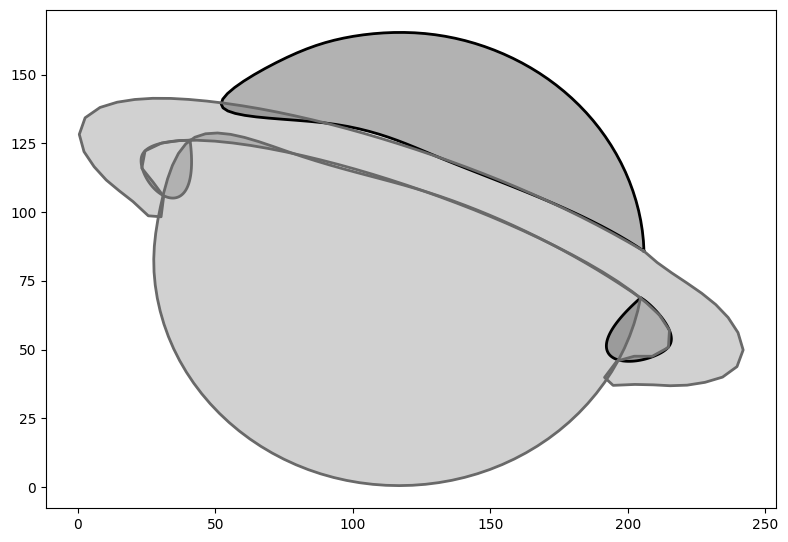

Error during connectivity check: 'MultiPolygon' object is not subscriptable
Displaying filled paths...


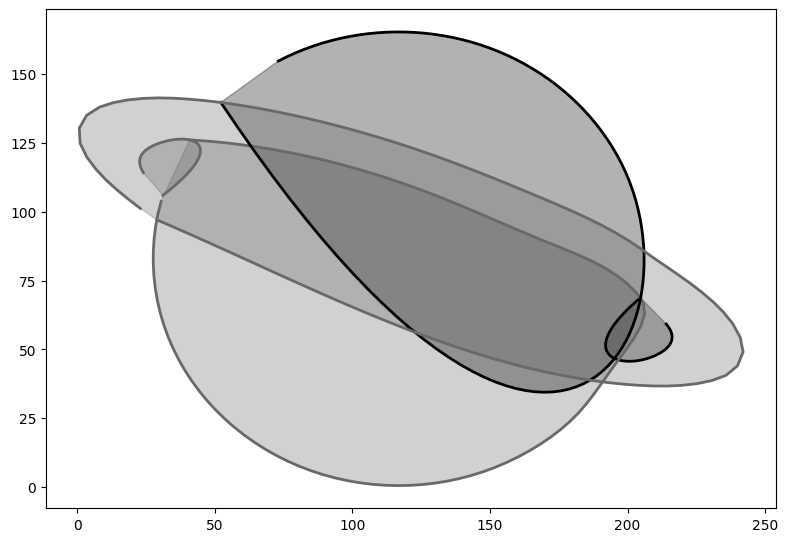

Initial connectivity: Not Connected
Final connectivity: Connected
Gaps have been filled
Displaying original paths...


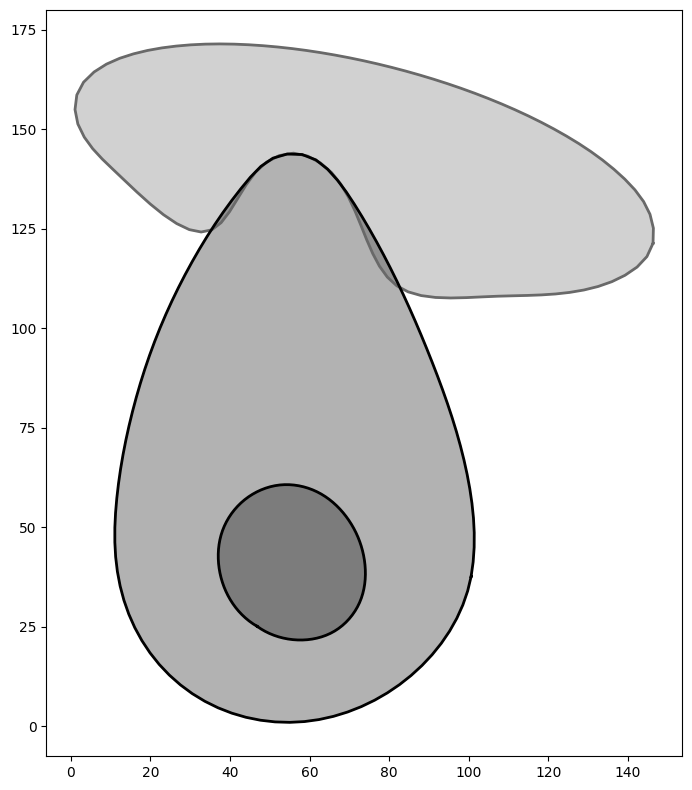

Displaying filled paths...


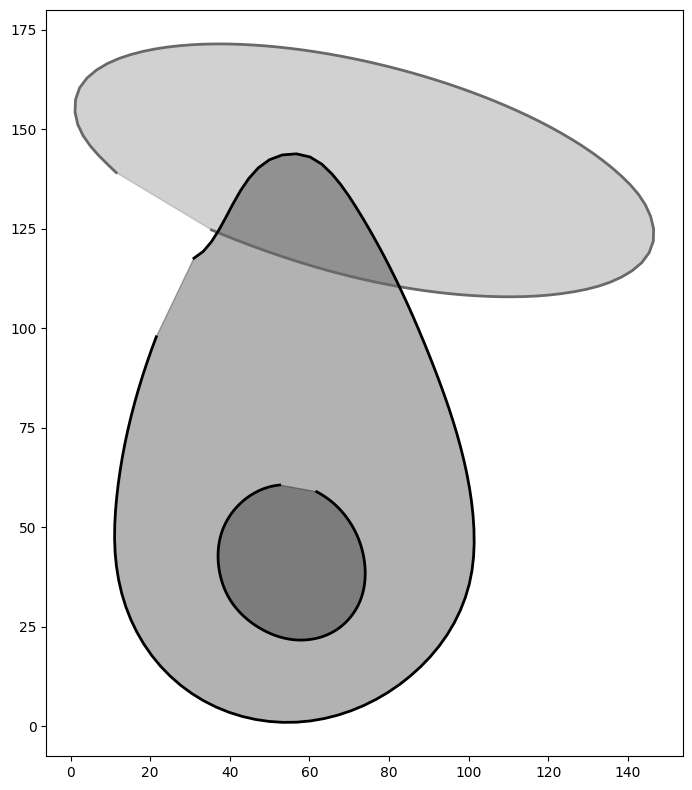

Initial connectivity: Connected
Final connectivity: Connected
No change in connectivity


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy.interpolate import splprep, splev
from shapely.geometry import Polygon, MultiPolygon, GeometryCollection
from shapely.ops import unary_union
from shapely.validation import make_valid
from rdp import rdp
import svgwrite
import cairosvg
from google.colab import files

# Function to simplify paths using the RDP algorithm
def simplify_paths(input_paths, tolerance=1.0):
    simplified_paths = []
    for path in input_paths:
        simplified_path = []
        for segment in path:
            if len(segment) > 2:
                try:
                    simplified_segment = rdp(segment, epsilon=tolerance)
                    simplified_path.append(simplified_segment)
                except Exception as e:
                    print(f"Error simplifying segment: {e}")
                    simplified_path.append(segment)
            else:
                simplified_path.append(segment)
        simplified_paths.append(simplified_path)
    return simplified_paths

# Function to fill occlusions using convex hulls
def close_gaps(paths):
    closed_paths = []
    for path in paths:
        closed_path = []
        for segment in path:
            if len(segment) > 2:  # Process only segments with more than 2 points
                try:
                    hull = ConvexHull(segment)
                    closed_segment = segment[hull.vertices]
                except Exception as e:
                    print(f"Error creating convex hull: {e}")
                    closed_segment = segment
            else:
                closed_segment = segment
            closed_path.append(closed_segment)
        closed_paths.append(closed_path)
    return closed_paths

# Function to create a Bezier curve for smooth paths
def create_bezier_curve(points, num_points=100):
    if len(points) < 2:
        return points
    try:
        tck, _ = splprep([points[:, 0], points[:, 1]], s=0)
        u_fine = np.linspace(0, 1, num_points)
        x_fine, y_fine = splev(u_fine, tck)
        return np.vstack((x_fine, y_fine)).T
    except Exception as e:
        print(f"Error fitting Bezier curve: {e}")
        return points

# Function to visualize paths using grayscale colors
def draw_paths(paths, colors):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, segments in enumerate(paths):
        color = colors[i % len(colors)]
        for segment in segments:
            try:
                if len(segment) > 2:
                    smooth_curve = create_bezier_curve(segment)
                    ax.plot(smooth_curve[:, 0], smooth_curve[:, 1], c=color, linewidth=2)
                    ax.fill(smooth_curve[:, 0], smooth_curve[:, 1], c=color, alpha=0.3)
                else:
                    ax.plot(segment[:, 0], segment[:, 1], c=color, linewidth=2)
                    ax.fill(segment[:, 0], segment[:, 1], c=color, alpha=0.3)
            except Exception as e:
                print(f"Error drawing path: {e}")
    ax.set_aspect('equal')
    plt.show()

# Function to analyze connectivity of paths
def check_connectivity(paths):
    shapes = []
    for path in paths:
        for segment in path:
            if len(segment) > 2:
                try:
                    shape = Polygon(segment)
                    if shape.is_valid:
                        shapes.append(shape)
                    else:
                        fixed_shape = make_valid(shape)
                        shapes.append(fixed_shape)
                except Exception as e:
                    print(f"Error creating polygon: {e}")

    if not shapes:
        return "Not Connected"

    try:
        multi_shape = MultiPolygon(shapes)
        unified_shape = unary_union(multi_shape)

        if isinstance(unified_shape, Polygon):
            return "Connected"
        elif isinstance(unified_shape, MultiPolygon):
            if len(unified_shape.geoms) == 1:
                return "Connected"
            else:
                return "Not Connected"
        elif isinstance(unified_shape, GeometryCollection):
            valid_shapes = [geom for geom in unified_shape.geoms if isinstance(geom, Polygon) and geom.is_valid]
            if valid_shapes:
                multi_shape = MultiPolygon(valid_shapes)
                if len(multi_shape.geoms) == 1:
                    return "Connected"
                else:
                    return "Not Connected"
            else:
                return "Not Connected"
    except Exception as e:
        print(f"Error during connectivity check: {e}")
        return "Not Connected"

# Main processing function
def analyze_and_fill_gaps(csv_file, gray_colors):
    # Load the CSV file
    paths = read_csv(csv_file)

    # Simplify paths
    simplified_paths = simplify_paths(paths, tolerance=1.0)
    print("Displaying original paths...")
    draw_paths(simplified_paths, gray_colors)
    initial_connectivity = check_connectivity(simplified_paths)

    # Fill gaps
    filled_paths = close_gaps(simplified_paths)
    print("Displaying filled paths...")
    draw_paths(filled_paths, gray_colors)
    final_connectivity = check_connectivity(filled_paths)

    print(f"Initial connectivity: {initial_connectivity}")
    print(f"Final connectivity: {final_connectivity}")

    if initial_connectivity == "Not Connected" and final_connectivity == "Connected":
        print("Gaps have been filled")
    else:
        print("No change in connectivity")

# Function to save paths as SVG and PNG
def export_to_svg(paths, svg_filename, gray_colors):
    # Determine the canvas size
    max_width, max_height = 0, 0
    for path in paths:
        for segment in path:
            max_width = max(max_width, np.max(segment[:, 0]))
            max_height = max(max_height, np.max(segment[:, 1]))

    padding = 0.1
    max_width, max_height = int(max_width + padding * max_width), int(max_height + padding * max_height)

    # Create the SVG drawing
    drawing = svgwrite.Drawing(svg_filename, profile='tiny', shape_rendering='crispEdges')
    group = drawing.g()

    for i, path in enumerate(paths):
        color = gray_colors[i % len(gray_colors)]
        for segment in path:
            try:
                path_commands = [("M", (segment[0, 0], segment[0, 1]))]
                for j in range(1, len(segment)):
                    path_commands.append(("L", (segment[j, 0], segment[j, 1])))
                if not np.allclose(segment[0], segment[-1]):
                    path_commands.append(("Z", None))
                group.add(drawing.path(d=path_commands, fill=color, stroke='none', stroke_width=2))
            except Exception as e:
                print(f"Error creating SVG path: {e}")

    drawing.add(group)
    drawing.save()

    # Convert SVG to PNG
    png_filename = svg_filename.replace('.svg', '.png')
    scale_factor = max(1, 1024 // min(max_height, max_width))
    try:
        cairosvg.svg2png(
            url=svg_filename,
            write_to=png_filename,
            parent_width=max_width,
            parent_height=max_height,
            output_width=scale_factor * max_width,
            output_height=scale_factor * max_height,
            background_color='white'
        )
    except Exception as e:
        print(f"Error converting SVG to PNG: {e}")

# Example usage
uploaded = files.upload()

# Analyze and fill occlusions for the first dataset
csv_file_1 = list(uploaded.keys())[0]
grayscale_colors = ['dimgray', 'black']

analyze_and_fill_gaps(csv_file_1, grayscale_colors)

paths_1 = read_csv(csv_file_1)
simplified_paths_1 = simplify_paths(paths_1, tolerance=1.0)
export_to_svg(simplified_paths_1, 'simplified_paths_1.svg', grayscale_colors)

# Analyze and fill occlusions for the second dataset
csv_file_2 = list(uploaded.keys())[1]
analyze_and_fill_gaps(csv_file_2, grayscale_colors)

paths_2 = read_csv(csv_file_2)
simplified_paths_2 = simplify_paths(paths_2, tolerance=1.0)
export_to_svg(simplified_paths_2, 'simplified_paths_2.svg', grayscale_colors)


end